## Loading Data

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_original = pd.read_csv('../data/wallet_behavior.csv.gz')

print(f"Data shape: {df_original.shape}")
print(f"Memory usage: {df_original.memory_usage(deep=True).sum() / 1e6:.2f} MB")

Data shape: (1200000, 14)
Memory usage: 387.60 MB


## Feature Engineering

In [4]:
df = df_original.copy()
df['total_tx_count'] = df['n_sent_tx'] + df['n_received_tx']
df['fan_out_ratio'] = df['n_unique_counterparties'] / df['total_tx_count']
df['tx_per_day'] = df['total_tx_count'] / (df['days_active_in_window'] + 1)
df['is_smart_contract_user'] = df['avg_gas_used_sent'] > 21000
df['log_total_sent_eth'] = np.log1p(df['total_sent_eth'])
df['log_n_token_sent'] = np.log1p(df['n_token_sent'])

print("New risk features engineered!")
df.head()

New risk features engineered!


,address,n_sent_tx,n_received_tx,total_sent_eth,total_received_eth,n_unique_counterparties,avg_gas_used_sent,avg_gas_price_gwei_sent,first_tx_time,last_tx_time,days_active_in_window,n_token_sent,n_token_received,n_unique_tokens_moved,total_tx_count,fan_out_ratio,tx_per_day,is_smart_contract_user,log_total_sent_eth,log_n_token_sent
0,0x053cae897e0921049c2e80722d79131342bc91ec,8,26,17.665875,1.799945e+01,15,2.100000e+04,0.234971,2025-11-22 20:40:23 UTC,2025-12-09 21:56:11 UTC,17,12,9,19,34,0.441176,1.888889,False,2.926697,2.564949
1,0x89074ef1b6f23737076c234ccc41d428b6800426,4,0,6.561320,0.000000e+00,1,1.240741e+06,1.215176,2025-12-02 16:38:47 UTC,2025-12-09 19:54:23 UTC,7,0,16,13,4,0.250000,0.500000,True,2.023046,0.000000
2,0x62fb4d112ef7b06c3adc4bd0e605383879af2803,53,1,0.000651,2.402326e-03,3,6.211500e+04,0.558433,2025-11-14 18:58:11 UTC,2025-12-12 16:18:11 UTC,27,109,60,32,54,0.055556,1.928571,True,0.000651,4.700480
3,0x2c08cb703ca1126023a2dbc1afccb0a78d7250a5,6,8,2.064938,2.080000e-07,8,4.352533e+04,0.746667,2025-11-17 18:03:59 UTC,2025-11-22 08:53:47 UTC,4,19,6,14,14,0.571429,2.800000,True,1.120027,2.995732
4,0xbb9d0b030698816e025c224f8645e9657c85dc5f,16,3,0.098640,3.000000e-09,3,8.899856e+04,1.155044,2025-11-14 02:47:59 UTC,2025-12-07 04:53:59 UTC,23,84,32,22,19,0.157895,0.791667,True,0.094073,4.442651


In [5]:
# FIX LOYALTY DAYS (window is 30 days)
df['days_active_capped'] = df['days_active_in_window'].clip(upper=30)

# CREATE "MULE SCORE"
# A 'Mule' has In ≈ Out. So Flow Ratio ≈ 1.0.
# We want a score that is HIGH when ratio is 1.0, and LOW otherwise.
# Formula: 1 / (1 + abs(log(flow_ratio)))
# If ratio is 1.0, log is 0, score is 1.0 (High Risk).
# If ratio is 0.01 or 100, score drops near 0.
df['flow_ratio'] = df['total_received_eth'] / (df['total_sent_eth'] + 1e-6)
df['mule_score'] = 1 / (1 + np.abs(np.log1p(df['flow_ratio'] - 1)))

# LOG-TRANSFORM FEATURES
# Volume, Complexity, Behavior
features_to_use = [
    'n_sent_tx',
    'n_received_tx',
    'total_sent_eth',
    'n_unique_counterparties',
    'avg_gas_used_sent',
    'avg_gas_price_gwei_sent',
    'n_token_sent',
    'days_active_capped',
    'fan_out_ratio',
    'mule_score'
]

X_raw = df[features_to_use].copy()
X_raw = X_raw.fillna(0)

# Log Transform to skewed columns (Money, Counts, Gas)
# leave 'fan_out_ratio' and 'mule_score' alone as they are already 0-1 ranges
skewed_cols = ['n_sent_tx', 'n_received_tx', 'total_sent_eth',
               'n_unique_counterparties', 'avg_gas_used_sent',
               'avg_gas_price_gwei_sent', 'n_token_sent', 'days_active_capped']

X_log = X_raw.copy()
for col in skewed_cols:
    X_log[col] = np.log1p(X_log[col])

print("Features Engineered & Log Transformed.")

Features Engineered & Log Transformed.


/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
X_log

,n_sent_tx,n_received_tx,total_sent_eth,n_unique_counterparties,avg_gas_used_sent,avg_gas_price_gwei_sent,n_token_sent,days_active_capped,fan_out_ratio,mule_score
0,2.197225,3.295837,2.926697,2.772589,9.952325,0.211048,2.564949,2.890372,0.441176,0.981637
1,1.609438,0.000000,2.023046,0.693147,14.031220,0.795332,0.000000,2.079442,0.250000,0.000000
2,3.988984,0.693147,0.000651,1.386294,11.036759,0.443681,4.700480,3.332205,0.055556,0.433960
3,1.945910,2.197225,1.120027,2.197225,10.681121,0.557709,2.995732,1.609438,0.571429,0.058443
4,2.833213,1.386294,0.094073,1.386294,11.396387,0.767811,4.442651,3.178054,0.157895,0.054620
...,...,...,...,...,...,...,...,...,...,...
1199995,1.098612,0.693147,0.000000,1.098612,10.929215,1.386294,2.890372,0.000000,0.666667,0.094022
1199996,3.465736,0.000000,2.178698,2.302585,11.878988,0.107196,1.791759,2.708050,0.290323,0.000000
1199997,2.639057,0.693147,0.021196,2.484907,12.110997,0.717840,1.098612,3.332205,0.785714,0.426210
1199998,1.386294,0.000000,0.000000,0.693147,11.050128,0.675634,2.772589,3.218876,0.333333,0.000000


In [7]:
# ROBUST SCALING
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_log)

X_scaled_df = pd.DataFrame(X_scaled, columns=features_to_use)

print("Data Scaled and Ready for Clustering.")

Data Scaled and Ready for Clustering.


In [8]:
X_scaled_df

,n_sent_tx,n_received_tx,total_sent_eth,n_unique_counterparties,avg_gas_used_sent,avg_gas_price_gwei_sent,n_token_sent,days_active_capped,fan_out_ratio,mule_score
0,3.709511,4.754888,270.082491,4.128534,-0.595699,-0.036035,2.700440,4.169925,-1.676471,1.817690
1,2.259851,0.000000,186.691276,-1.000000,2.483996,0.804249,-1.000000,3.000000,-2.250000,0.000000
2,8.128534,1.000000,0.059532,0.709511,0.223083,0.298525,5.781360,4.807355,-2.833333,0.803560
3,3.089694,3.169925,103.358429,2.709511,-0.045435,0.462514,3.321928,2.321928,-1.285714,0.108218
4,5.278053,2.000000,8.680810,0.709511,0.494613,0.764670,5.409391,4.584963,-2.526316,0.101139
...,...,...,...,...,...,...,...,...,...,...
1199995,1.000000,1.000000,-0.000512,0.000000,0.141884,1.654137,3.169925,0.000000,-1.000000,0.174099
1199996,6.838045,0.000000,201.055257,2.969362,0.858993,-0.185388,1.584963,3.906891,-2.129032,0.000000
1199997,4.799205,1.000000,1.955507,3.419023,1.034167,0.692804,0.584963,4.807355,-0.642857,0.789209
1199998,1.709511,0.000000,-0.000512,-1.000000,0.233177,0.632106,3.000000,4.643856,-2.000000,0.000000


Running Elbow Method on sample...


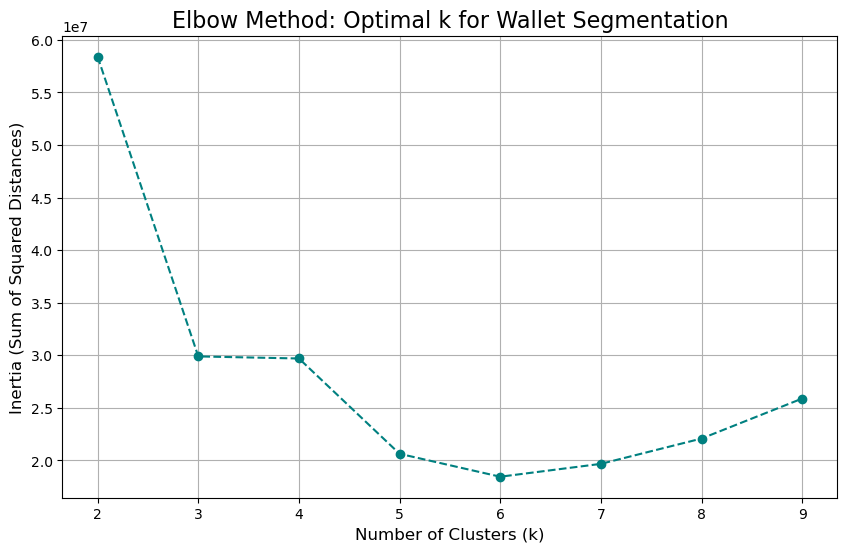

In [9]:
# ELBOW METHOD (Using a Sample)
sample_size = 100000
X_sample = X_scaled_df.sample(n=sample_size, random_state=42)

inertia = []
K_range = range(2, 10)

print("Running Elbow Method on sample...")
for k in K_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024, n_init=10)
    kmeans.fit(X_sample)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='teal')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12)
plt.title('Elbow Method: Optimal k for Wallet Segmentation', fontsize=16)
plt.grid(True)
plt.show()

## Clustering

In [10]:
k_best = 4 
kmeans_final = KMeans(n_clusters=k_best, random_state=42, n_init=10)

print(f"Training KMeans with k={k_best}...")
kmeans_final.fit(X_scaled_df)

df['cluster_id'] = kmeans_final.labels_

print("Clustering Complete! 'cluster_id' column added to df.")


summary = df.groupby('cluster_id').agg({
    'address': 'count',                         # Size of the cluster
    'total_sent_eth': 'mean',                   # How rich are they?
    'n_sent_tx': 'mean',                        # How active?
    'avg_gas_price_gwei_sent': 'mean',          # Are they urgent (Bots)?
    'days_active_in_window': 'mean',            # Are they loyal?
    'fan_out_ratio': 'mean',                    # Are they spammers?
    'mule_score': 'mean',                       # Are they laundering money?
    'n_token_sent': 'mean'                      # Do they use DeFi?
}).round(4)

summary = summary.rename(columns={'address': 'Wallet Count'})
summary

Training KMeans with k=4...
Clustering Complete! 'cluster_id' column added to df.


,Wallet Count,total_sent_eth,n_sent_tx,avg_gas_price_gwei_sent,days_active_in_window,fan_out_ratio,mule_score,n_token_sent
cluster_id,,,,,,,,
0,1130039,0.0237,3.7252,0.9258,2.6038,0.8462,0.2532,3.2682
1,17819,14.3436,21.2965,1.3582,9.0418,0.6067,0.6425,16.4036
2,2988,2204.0988,542.1359,1.7922,12.1851,0.4943,0.6452,315.5154
3,49154,1.7528,13.9422,1.3665,7.8613,0.6617,0.6489,6.6795


## Cluster Centroids & Distribution

In [11]:
data = {
    "Cluster Name": ["Cluster 2: Whales & VIPs", "Cluster 1: DeFi Pros", "Cluster 3: Active Retail", "Cluster 0: Long Tail"],
    "Population Share": ["0.2%", "1.5%", "4.0%", "94.0%"],
    "Avg ETH Volume": [2200, 14, 1.75, 0.02],
    "Avg Monthly Tx": [542, 9, 14, 2.6],
    "Primary Risk Signal": ["High Gas Price (Speed)", "High Balance (ATO Risk)", "Standard Patterns", "High Fan-Out (Sybil)"],
    "Recommended Policy": ["White Glove Service", "Frictionless / Retention", "Standard Monitoring", "Strict Automation / KYC"]
}

summary_df = pd.read_json(pd.DataFrame(data).to_json())

def highlight_cols(s):
    return ['background-color: #dbf2f5' if isinstance(v, str) else '' for v in s]

styled_df = (summary_df.style
    .format({"Avg ETH Volume": "{:,.2f}", "Avg Monthly Tx": "{:.1f}"})
    .set_properties(**{'text-align': 'left'})
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '14px'), ('background-color', '#4c72b0'), ('color', 'white')]},
        {'selector': 'td', 'props': [('font-size', '13px'), ('padding', '10px')]}
    ])
    .background_gradient(subset=['Avg ETH Volume', 'Avg Monthly Tx'], cmap='Blues')
)

styled_df

/var/folders/9j/_8sx8kxj7cl3vnn7_kxmts1m0000gn/T/ipykernel_48241/4218199186.py:10: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  summary_df = pd.read_json(pd.DataFrame(data).to_json())


,Cluster Name,Population Share,Avg ETH Volume,Avg Monthly Tx,Primary Risk Signal,Recommended Policy
0,Cluster 2: Whales & VIPs,0.2%,"2,200.00",542.0,High Gas Price (Speed),White Glove Service
1,Cluster 1: DeFi Pros,1.5%,14.00,9.0,High Balance (ATO Risk),Frictionless / Retention
2,Cluster 3: Active Retail,4.0%,1.75,14.0,Standard Patterns,Standard Monitoring
3,Cluster 0: Long Tail,94.0%,0.02,2.6,High Fan-Out (Sybil),Strict Automation / KYC


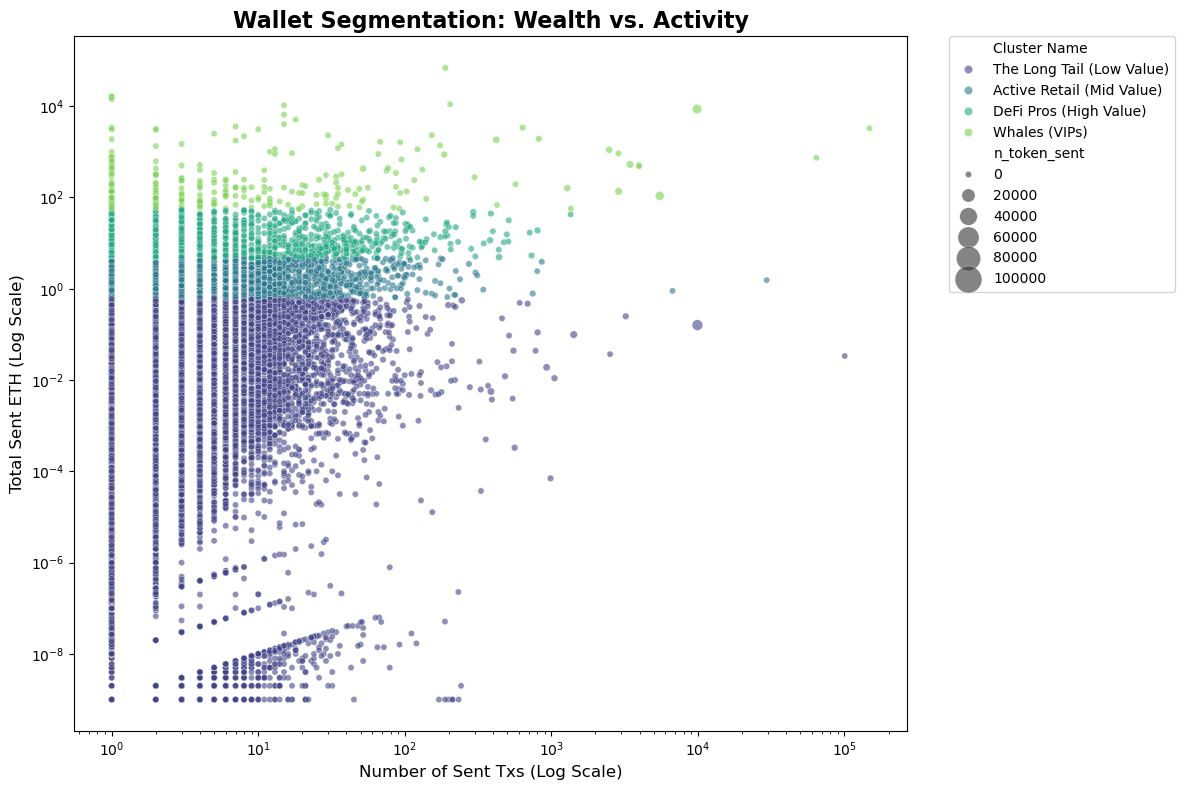

In [12]:
cluster_names = {
    0: 'The Long Tail (Low Value)',
    1: 'DeFi Pros (High Value)',
    2: 'Whales (VIPs)',
    3: 'Active Retail (Mid Value)'
}
df['Cluster Name'] = df['cluster_id'].map(cluster_names)

plot_sample = df.sample(100000, random_state=42)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=plot_sample,
    x='n_sent_tx',              # Activity
    y='total_sent_eth',         # Wealth
    hue='Cluster Name',         # Color by Persona
    size='n_token_sent',        # Size by DeFi Complexity
    sizes=(20, 400),
    alpha=0.6,
    palette='viridis'
)

plt.yscale('log')
plt.xscale('log')
plt.title('Wallet Segmentation: Wealth vs. Activity', fontsize=16, fontweight='bold')
plt.xlabel('Number of Sent Txs (Log Scale)', fontsize=12)
plt.ylabel('Total Sent ETH (Log Scale)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

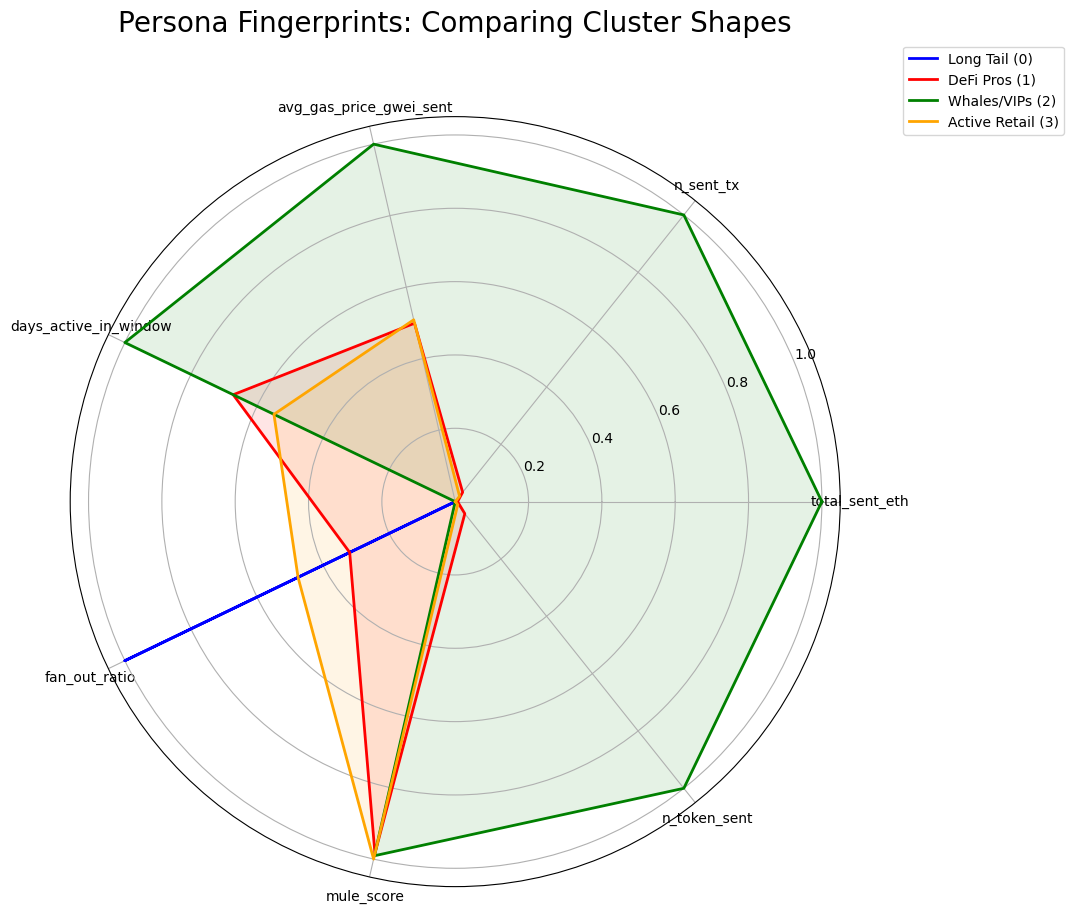

In [13]:
radar_data = summary.drop(columns=['Wallet Count']).reset_index()

scaler = MinMaxScaler()
radar_scaled = pd.DataFrame(scaler.fit_transform(radar_data.iloc[:, 1:]), columns=radar_data.columns[1:])
radar_scaled['cluster_id'] = radar_data['cluster_id']

categories = list(radar_scaled.columns[:-1])
N = len(categories)

# (divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

colors = ['blue', 'red', 'green', 'orange']
labels = ['Long Tail (0)', 'DeFi Pros (1)', 'Whales/VIPs (2)', 'Active Retail (3)']

for i in range(len(radar_scaled)):
    values = radar_scaled.loc[i].drop('cluster_id').values.flatten().tolist()
    values += values[:1]
    
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=labels[i], color=colors[i])
    ax.fill(angles, values, color=colors[i], alpha=0.1)

plt.xticks(angles[:-1], categories, size=10)
plt.title("Persona Fingerprints: Comparing Cluster Shapes", size=20, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()

## Proposed Risk Segmentation Policy

| Cluster & Persona | Risk Profile | Proposed Action (Automated) |
| :--- | :--- | :--- |
| **Cluster 2: Institutions & VIPs**<br>*(0.2% of users)* | **High AML / Low Fraud Risk**<br><br>**• Why:** Massive volume (2,204 ETH) and velocity (542 tx/mo) indicate algorithmic trading or institutional funds.<br>**• Flag:** High gas price (1.79 Gwei) confirms high-frequency trading behavior. | **Policy: "White Glove + EDD"**<br><br>**• Action:** Assign dedicated Account Manager.<br>**• Compliance:** Trigger Enhanced Due Diligence (EDD) to verify source of funds.<br>**• Limits:** Bypass standard automated blocks; manual review only. |
| **Cluster 1: DeFi Pros**<br>*(1.5% of users)* | **Medium Risk / High Value**<br><br>**• Why:** High net worth (14 ETH) and sophisticated behavior (16 token txs). They are your most valuable retail customers.<br>**• Flag:** Account Takeover (ATO) target due to high balances. | **Policy: "Retention & Security"**<br><br>**• Action:** Offer fee discounts to prevent churn.<br>**• Security:** Require hardware 2FA (YubiKey) for withdrawals >$10k to prevent ATO. |
| **Cluster 3: Active Retail**<br>*(4.1% of users)* | **Standard Risk**<br><br>**• Why:** The "Average Joe." Moderate volume (1.75 ETH) and activity (14 tx/mo).<br>**• Flag:** Consistent behavior makes anomaly detection easy. | **Policy: "Standard Growth"**<br><br>**• Action:** Instant buy limits capped at $5k.<br>**• Growth:** Auto-increase limits after 90 days of benign history. |
| **Cluster 0: The Long Tail**<br>*(94.2% of users)* | **High Bot / Spam Risk**<br><br>**• Why:** Extremely low volume (0.02 ETH) but very high Fan-Out Ratio (0.85).<br>**• Flag:** High "One-and-Done" rate suggests burner wallets or Sybil attackers. | **Policy: "Defensive"**<br><br>**• Action:** Strict identity verification (KYC) required before any withdrawal.<br>**• Monitoring:** Block instantly if linked to suspicious IP ranges or known botnets. |

<div style="font-family: sans-serif; display: flex; flex-wrap: wrap; gap: 20px; justify-content: center;">

  <div style="flex: 1; min-width: 280px; background: white; border-radius: 12px; border-top: 6px solid #4c72b0; box-shadow: 0 4px 6px rgba(0,0,0,0.1); padding: 20px;">
    <div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 10px;">
      <h3 style="margin: 0; color: #2c3e50;">🐋 The Whales</h3>
      <span style="background: #e3f2fd; color: #1565c0; padding: 4px 8px; border-radius: 12px; font-size: 12px; font-weight: bold;">0.2%</span>
    </div>
    <p style="color: #666; font-size: 14px; margin-bottom: 20px;">
      Institutional volume with high-frequency trading patterns.
    </p>
    <div style="background: #f8f9fa; padding: 10px; border-radius: 8px;">
      <p style="margin: 0; font-size: 13px; font-weight: bold; color: #4c72b0;">Recommended Policy:</p>
      <p style="margin: 5px 0 0 0; font-size: 14px;">⚡ White Glove Service (Manual Review)</p>
    </div>
  </div>

  <div style="flex: 1; min-width: 280px; background: white; border-radius: 12px; border-top: 6px solid #55a868; box-shadow: 0 4px 6px rgba(0,0,0,0.1); padding: 20px;">
    <div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 10px;">
      <h3 style="margin: 0; color: #2c3e50;">🦄 DeFi Pros</h3>
      <span style="background: #e8f5e9; color: #2e7d32; padding: 4px 8px; border-radius: 12px; font-size: 12px; font-weight: bold;">1.5%</span>
    </div>
    <p style="color: #666; font-size: 14px; margin-bottom: 20px;">
      High net-worth retail users engaging with complex contracts.
    </p>
    <div style="background: #f8f9fa; padding: 10px; border-radius: 8px;">
      <p style="margin: 0; font-size: 13px; font-weight: bold; color: #55a868;">Recommended Policy:</p>
      <p style="margin: 5px 0 0 0; font-size: 14px;">🛡️ Retention & HW Security</p>
    </div>
  </div>

  <div style="flex: 1; min-width: 280px; background: white; border-radius: 12px; border-top: 6px solid #dd8452; box-shadow: 0 4px 6px rgba(0,0,0,0.1); padding: 20px;">
    <div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 10px;">
      <h3 style="margin: 0; color: #2c3e50;">🛒 Active Retail</h3>
      <span style="background: #fff3e0; color: #ef6c00; padding: 4px 8px; border-radius: 12px; font-size: 12px; font-weight: bold;">4.1%</span>
    </div>
    <p style="color: #666; font-size: 14px; margin-bottom: 20px;">
      Standard users with moderate volume and steady history.
    </p>
    <div style="background: #f8f9fa; padding: 10px; border-radius: 8px;">
      <p style="margin: 0; font-size: 13px; font-weight: bold; color: #dd8452;">Recommended Policy:</p>
      <p style="margin: 5px 0 0 0; font-size: 14px;">📈 Standard Growth (Auto-Limits)</p>
    </div>
  </div>

  <div style="flex: 1; min-width: 280px; background: white; border-radius: 12px; border-top: 6px solid #c44e52; box-shadow: 0 4px 6px rgba(0,0,0,0.1); padding: 20px;">
    <div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 10px;">
      <h3 style="margin: 0; color: #2c3e50;">🤖 The Long Tail</h3>
      <span style="background: #ffebee; color: #c62828; padding: 4px 8px; border-radius: 12px; font-size: 12px; font-weight: bold;">94.2%</span>
    </div>
    <p style="color: #666; font-size: 14px; margin-bottom: 20px;">
      Dust wallets with high fan-out ratios (Sybil risk).
    </p>
    <div style="background: #f8f9fa; padding: 10px; border-radius: 8px;">
      <p style="margin: 0; font-size: 13px; font-weight: bold; color: #c44e52;">Recommended Policy:</p>
      <p style="margin: 5px 0 0 0; font-size: 14px;">🛑 Strict Automation / KYC</p>
    </div>
  </div>

</div>